In [27]:
using BenchmarkTools
using Plots

include("parallelized_DLA.jl")

Main.DLA_parallel

## Initialize constants

In [28]:
desired_cluster_mass = 2500
spawn_density = 0.8
num_steps = 10_000
max_radius = 150
spawn_cap = 300
deposit_prob = 1
;

In [ ]:
@time cluster = DLA_parallel.run_parallel_DLA(desired_cluster_mass, spawn_density, num_steps, max_radius, spawn_cap, deposit_prob)

 Mass = 2427, r_B = 64, r_D = 128 

In [ ]:
fig = scatter()
scatter!(fig, ([v[1] for v in cluster], [v[2] for v in cluster]), label="")

# Appendix 1: Obtaining the grid points on a circle

In [2]:
r = 12
θ = range(-π, π, 300)

grid_circle = Utils.get_circle_points(r)
round_circle = [r * cos.(θ), r* sin.(θ)]
;

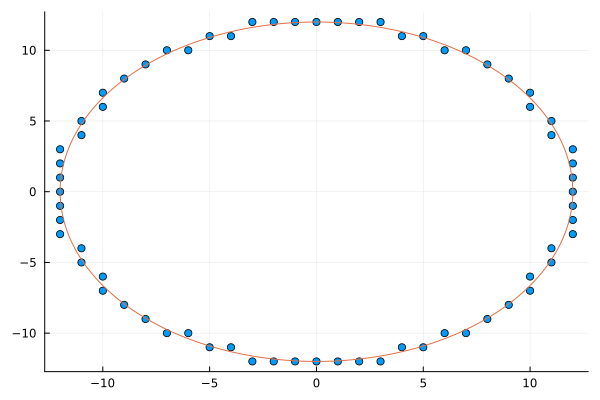

In [3]:
fig = scatter([v[1] for v in grid_circle], [v[2] for v in grid_circle], label="")
plot!(fig, (round_circle[1], round_circle[2]), label="")

#### Get number of grid points for each radius

In [4]:
radii = collect(1:80)
num_gridpoints_on_circle = map(
    x -> length(Utils.get_circle_points(x)),
    radii
)
;

Perform linear regression

In [5]:
using DataFrames, GLM, StatsBase

In [6]:
data = DataFrame(X=radii, Y=num_gridpoints_on_circle)
ols = lm(@formula(Y ~ X), data)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

Y ~ 1 + X

Coefficients:
───────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error        t  Pr(>|t|)  Lower 95%  Upper 95%
───────────────────────────────────────────────────────────────────────────
(Intercept)  -0.110127  0.263293      -0.42    0.6769  -0.634303   0.414049
X             5.65827   0.00564754  1001.90    <1e-99   5.64703    5.66952
───────────────────────────────────────────────────────────────────────────

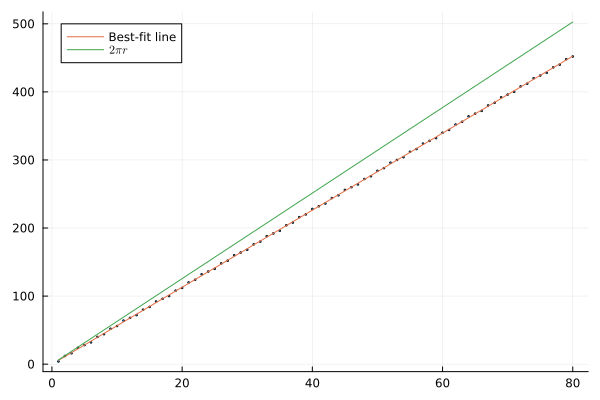

In [7]:
fig = scatter(radii, num_gridpoints_on_circle, markersize=1, label="")
plot!(fig, (radii, predict(ols)), label="Best-fit line")

plot!(fig, (radii, (2*pi) .* radii), label=raw"$2\pi r$")

#### Benchmarking

In [8]:
r = 100_000
@benchmark Utils.get_circle_points($r)

BenchmarkTools.Trial: 10000 samples with 997 evaluations.
 Range (min … max):  21.966 ns …  5.673 μs  ┊ GC (min … max): 0.00% … 99.04%
 Time  (median):     25.677 ns              ┊ GC (median):    0.00%
 Time  (mean ± σ):   27.882 ns ± 78.704 ns  ┊ GC (mean ± σ):  4.41% ±  1.70%

        ▄█▁▇▄▃▁▂                                               
  ▂▃▃▄▅█████████▄▅▃▃▃▃▃▅▄▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂ ▃
  22 ns           Histogram: frequency by time        43.6 ns <

 Memory estimate: 16 bytes, allocs estimate: 1.